In [16]:
using Pkg; Pkg.activate("../.././test/.") # activate test environment
using Revise # load test packages
@time using DEBBase # should be added using "dev ." instead of "add .", so that current version is always loaded
using Plots, StatsPlots
default(titlefontsize = 10, lw = 1.5, leg = false)

  Activating project at `c:\Users\simon\Documents\Julia\DEBBase.jl\test`


  0.007791 seconds (611 allocations: 37.547 KiB)


In [17]:
using StatsPlots

## Default parameters

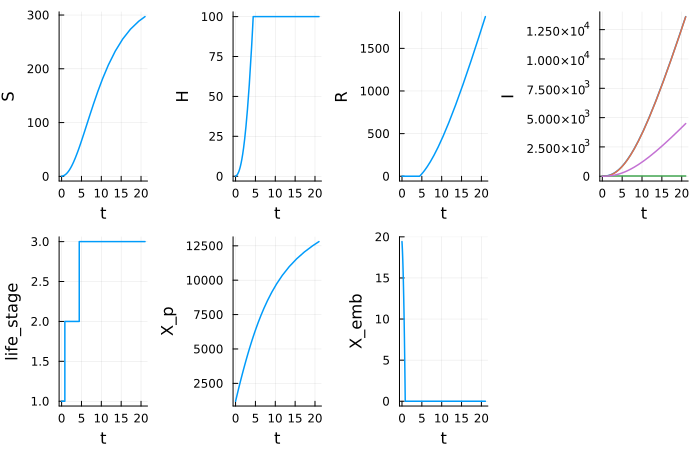

In [18]:
p = BaseParamCollection()
out = simulator(p)

@df out plot(
    plot(:t, :S, ylabel = "S"), 
    plot(:t, :H, ylabel = "H"),
    plot(:t, :R, ylabel = "R"), 
    plot(:t, [:I, :I_p, :I_emb, :A], ylabel = "I"), 
    plot(:t, :life_stage, ylabel = "life_stage"),
    plot(:t, :X_p, ylabel = "X_p"), 
    plot(:t, :X_emb, ylabel = "X_emb"),
    xlabel = "t", 
    size = (700,450), 
    layout = (2,4)
)


## Effect of nutrient input on growth and reproduction

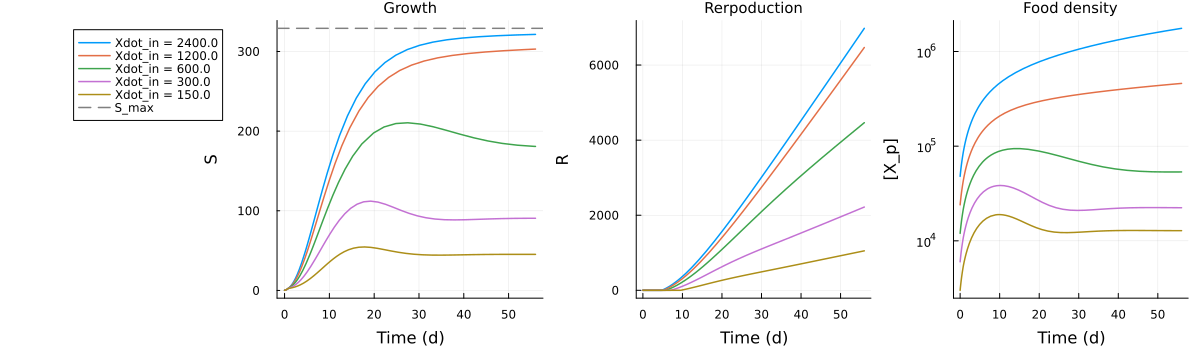

In [21]:
using Revise
using Plots, StatsPlots, Plots.Measures
default(titlefontsize = 10, leg = false)
norm(x) = x ./ (sum(x))

# prepare the plot
plt = plot(
    layout = grid(1,3, widths = norm([2, 1, 1])),
    leg = false, 
    title = ["Growth" "Rerpoduction" "Food density"], 
    leftmargin = 5mm, bottommargin = 6mm, 
    size = (1200,350), 
    xlabel = "Time (d)"
    )

# iterate over nutrient input concentrations
Xdot_in = 4800.
for _ in 1:5
    Xdot_in /= 2
    # generate the predidction
    out = simulator(
        BaseParamCollection(
            glb = GlobalBaseParams(Xdot_in = Xdot_in, t_max = 56.), 
            deb = DEBBaseParams(K_X = 12e3))
        )

    # plot the trajectories
    @df out plot!(plt, :t, :S, ylabel = "S", subplot = 1, leg = :outertopleft, label = "Xdot_in = $(Xdot_in)") 
    @df out plot!(plt, :t, :R, ylabel = "R", subplot = 2)
    @df out plot!(plt, :t, :X_p ./ GlobalBaseParams().V_patch, ylabel = "[X_p]", subplot = 3, 
        yscale = :log10
        )
end
hline!(plt, [DEBBase.calc_S_max(DEBBaseParams())], linestyle = :dash, color = "gray", subplot = 1, label = "S_max")
display(plt)


## Benchmarking & Profiling

Introducing sigmoid switches decreased computation times considerably. With more optimization, it should be possible to get below 5 ms / simulation (200 simulations / s). <br>
Optimization should focus on the TKTD functions. Most of the computation time is spent on `y!()` and `Ddot!()`. By outcommenting these functions, we can get computation times down to 1.6 ms / sim!

In [22]:
using Dates
@time begin # forcing the code to run for 1 minute, to compare with output of @benchmark
    t0 = now()
    i = 0.
    while now() - t0 <= Second(60)
        out = simulator(
            BaseParamCollection(
                glb = GlobalBaseParams(Xdot_in = 4800., t_max = 21.), 
                deb = DEBBaseParams(K_X = 12e3))
            )
        i += 1
    end
    println("Carried out $i simulations in $Second((now() - t0)).")
end

Carried out 3511.0 simulations in Second((now() - t0)).
 60.003620 seconds (635.36 M allocations: 23.376 GiB, 5.24% gc time, 0.04% compilation time)


A relatively large chunk of the computation time is spent on TKTD functions, mostp importantly 

In [31]:
using BenchmarkTools
using DEBBase

@benchmark out = simulator(
        BaseParamCollection(
            glb = GlobalBaseParams(Xdot_in = 4800., t_max = 21.), 
            deb = DEBBaseParams(K_X = 12e3))
        )

BenchmarkTools.Trial: 2787 samples with 1 evaluation.
 Range (min … max):  1.568 ms …   5.774 ms  ┊ GC (min … max): 0.00% … 49.96%
 Time  (median):     1.643 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.790 ms ± 506.845 μs  ┊ GC (mean ± σ):  4.47% ± 10.12%

  ▇█▆▅▄▃▂▁                                                    ▁
  ██████████▇▇██▅▆▅▃▆▄▃▃▄▃▄▃▃▄▄▄▄▅▅▅▆▆▃▃▁▁▃▁▁▁▃▁▄▃▆▇▇▅▆▆▆▅▆▄▆ █
  1.57 ms      Histogram: log(frequency) by time      4.29 ms <

 Memory estimate: 1.49 MiB, allocs estimate: 76644.

In [28]:
using ProfileView
ProfileView.@profview(simulator(BaseParamCollection()))

Gtk.GtkWindowLeaf(name="", parent, width-request=-1, height-request=-1, visible=TRUE, sensitive=TRUE, app-paintable=FALSE, can-focus=FALSE, has-focus=FALSE, is-focus=FALSE, focus-on-click=TRUE, can-default=FALSE, has-default=FALSE, receives-default=FALSE, composite-child=FALSE, style, events=0, no-show-all=FALSE, has-tooltip=FALSE, tooltip-markup=NULL, tooltip-text=NULL, window, opacity=1.000000, double-buffered, halign=GTK_ALIGN_FILL, valign=GTK_ALIGN_FILL, margin-left, margin-right, margin-start=0, margin-end=0, margin-top=0, margin-bottom=0, margin=0, hexpand=FALSE, vexpand=FALSE, hexpand-set=FALSE, vexpand-set=FALSE, expand=FALSE, scale-factor=1, border-width=0, resize-mode, child, type=GTK_WINDOW_TOPLEVEL, title="Profile  -  16:37:37", role=NULL, resizable=TRUE, modal=FALSE, window-position=GTK_WIN_POS_NONE, default-width=800, default-height=600, destroy-with-parent=FALSE, hide-titlebar-when-maximized=FALSE, icon, icon-name=NULL, screen, type-hint=GDK_WINDOW_TYPE_HINT_NORMAL, skip

In [ ]:
using 